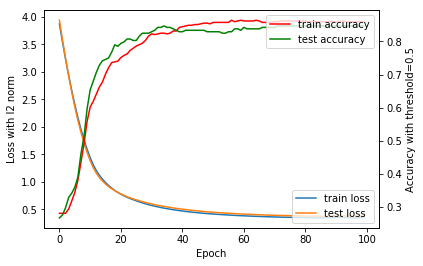

In [1]:

import numpy as np 
import scipy  
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

def h(w,X):
    return X.dot(w)

def hinge_loss(w,X,Y,C=1.0):
    num_records,num_features  = np.shape(X)  
    zero = np.zeros((num_records,1))
    margin = 1 - C * Y * h(w,X)
    return np.max([zero,margin],axis=0)

def L(w,X,Y,lamda=0.0,C=1.0):
    num_records,num_features  = np.shape(X)  
    e = hinge_loss(w,X,Y,C)
    regulation_loss = 1.0/2 * lamda * w.transpose().dot(w)
    loss = 1.0/float(num_records) * e.sum()  + regulation_loss
    return loss[0][0]

def g(w,X,Y,lamda=0.0,C=1.0):
    num_records,num_features  = np.shape(X)  
    e = hinge_loss(w,X,Y,C)
    indicator = np.zeros((num_records,1))
    indicator[np.nonzero(e)] = 1
    
    return - 1.0/float(num_records) * C \
        * X.transpose().dot(Y * indicator).sum(axis=1).reshape((num_features,1)) \
        + lamda * w
    
def predict(w,X,threshold=0.5):
    raw = h(w,X)
    raw[raw<=threshold] = -1
    raw[raw>threshold] = 1
    return raw

def accuracy(w,X,Y,threshold=0.5):
    num_records,num_features  = np.shape(X)  
    P = predict(w,X,threshold)
    
    is_right = P * Y
    is_right[is_right < 0] = 0
    
    return 1.0/num_records * np.count_nonzero(is_right)

data = load_svmlight_file("./australian.txt")
# add interception
X = scipy.sparse.hstack(\
    (scipy.sparse.csr_matrix(np.ones((len(data[1]),1))),data[0]))
Y = data[1].reshape((len(data[1]),1))

num_records,num_features  = np.shape(X) 

X_train, X_test, Y_train, Y_test = train_test_split(\
X, Y, test_size=0.33,random_state=42)
Y_train = Y_train.reshape((len(Y_train),1))
Y_test = Y_test.reshape((len(Y_test),1))

# initialize w
w = np.random.normal(size=(num_features,1))

lamda = 0.1
eta = 0.2
C = 1.0
threshold=0.5
max_iterate = 100
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []

for epoch in range(max_iterate):
    #print("epoch:",epoch)
    loss_train.append(L(w,X_train,Y_train,lamda,C))
    loss_test.append(L(w,X_test,Y_test,lamda,C))
    accuracy_train.append(accuracy(w,X_train,Y_train,threshold))
    accuracy_test.append(accuracy(w,X_test,Y_test,threshold))
    w = w - eta * g(w,X_train,Y_train,lamda,C)

fig, ax = plt.subplots()
ax_e = ax.twinx()
train_loss_line = ax.plot(range(max_iterate),loss_train,label='train loss')
test_loss_line = ax.plot(range(max_iterate),loss_test,label='test loss')
train_accuracy_line = ax_e.plot(range(max_iterate),accuracy_train,'r',label='train accuracy')
test_accuracy_line = ax_e.plot(range(max_iterate),accuracy_test,'g',label='test accuracy')

ax.set(xlabel='Epoch', ylabel='Loss with l2 norm')
ax_e.set_ylabel('Accuracy with threshold='+str(threshold))

ax.legend(loc=4)
ax_e.legend(loc=1)
plt.show()